In [1]:

from load_data import *
from pr2_utils import *
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from numba import njit,prange
from numba import jit
import cv2
from tqdm import tqdm
import transforms3d




In [2]:
### DEFINING THE NECESSARY VARIABLES ###

dataset = 20
N = 100
lidar_data = np.load("/home/prithwiraj/Desktop/ECE276A_PR2/data/Hokuyo%d.npz"%dataset)
encoder_data = np.load("/home/prithwiraj/Desktop/ECE276A_PR2/data/Encoders%d.npz"%dataset)
imu_data=np.load("/home/prithwiraj/Desktop/ECE276A_PR2/data/Imu%d.npz"%dataset)
disp_path = "/home/prithwiraj/Desktop/ECE276A_PR2/data/dataRGBD/Disparity20/"
rgb_path = "/home/prithwiraj/Desktop/ECE276A_PR2/data/dataRGBD/RGB20/"
kinect_data = np.load("/home/prithwiraj/Desktop/ECE276A_PR2/data/Kinect%d.npz"%dataset)

wheel_base = 0.311
np.set_printoptions(threshold=np.inf)

In [3]:

lidar_range_data= lidar_data["ranges"]
lidar_angle_inc=lidar_data["angle_increment"]
lidar_stamps = lidar_data["time_stamps"]
lidar_angle_min = lidar_data["angle_min"] # start angle of the scan [rad]
lidar_angle_max = lidar_data["angle_max"] # end angle of the scan [rad]
lidar_angles=np.linspace(lidar_angle_min,lidar_angle_max,lidar_range_data.shape[0])




In [4]:
def lidar_2_cart(r_data):
    '''
    converts lidar range data to cartesian coordinates in lidar frame
    input -> r_data : lidar scan in range

    '''
    lidar_angles=np.linspace(lidar_angle_min,lidar_angle_max,1081)
    X_L=r_data*np.cos(lidar_angles)
    Y_L=r_data*np.sin(lidar_angles)
    Z_L=[0]*1081
    cart=np.vstack((X_L,Y_L,Z_L))
    return cart.T

def lidar_cart_2_body(p):
    '''
    function converts cartesian coordinates in lidar frame to robot body frame
    input -> p: cartesian coordinate of single lidar scan ray
    '''
    X,Y,Z=p
    R_lidar_2_body = np.eye(3)
    lidar_2_body = np.matmul(R_lidar_2_body,np.array([[X],[Y],[Z]]))+np.array([[0.13673],[0],[0.320675]])
    X_B,Y_B,Z_B=lidar_2_body
    return [X_B,Y_B,Z_B]


lidar_cart=np.apply_along_axis(lidar_2_cart,0,lidar_range_data)

lidar_mes_body=np.empty(list(lidar_cart.shape))

for i in range(lidar_mes_body.shape[2]):
    lidar_mes_body[:,:,i]=np.apply_along_axis(lidar_cart_2_body,1,lidar_cart[:,:,i])[:,:,0]

In [5]:
## ENCODER READINGS ##

encoder_counts = encoder_data["counts"] # 4 x n encoder counts
encoder_stamps = encoder_data["time_stamps"] # encoder time stamps

dist_RW=(encoder_counts[0,:] + encoder_counts[2,:])*0.0022/2
dist_LW=(encoder_counts[1,:] + encoder_counts[3,:])*0.0022/2

encoder_tau=np.empty([1,encoder_stamps.shape[0]-1])

for i in range(encoder_stamps.shape[0]-1):
    encoder_tau[0,i]=encoder_stamps[i+1]-encoder_stamps[i]

V_R=dist_RW[1:]/encoder_tau[0,:]
V_L=dist_LW[1:]/encoder_tau[0,:]

V_Robot=(V_R+V_L)/2

yaw_rate = (V_R - V_L)/wheel_base







# plt.plot(encoder_counts[3,:])
# plt.show()
#encoder_stamps.shape


In [6]:
# Motion Model for Differential Drive Robot

imu_stamps = imu_data["time_stamps"]  # acquisition times of the imu measurements
imu_angular_velocity = imu_data["angular_velocity"] # angular velocity in rad/sec
imu_linear_acceleration = imu_data["linear_acceleration"] # Accelerations in gs (gravity acceleration scaling)


# storing the timestamps

time_index = {}
for t in encoder_stamps:
  time_diff = np.abs(imu_stamps - t)
  index = np.argmin(time_diff)
  time_index[t] = index

time_index_lidar = {}
for t in encoder_stamps:
  time_diff = np.abs(lidar_stamps - t)
  index = np.argmin(time_diff)
  time_index_lidar[t] = index


tau=np.empty([1,encoder_stamps.shape[0]-1])
for i in range(encoder_stamps.shape[0]-1):
    tau[0][i]=encoder_stamps[i+1]-encoder_stamps[i]

In [7]:

def lidar_scan_to_world(scan,pose):
    '''
    function to convert the lidar scan in body frame to world frame
    '''

    x,y,theta=pose
    #print(x,y,theta)
    Rot_mat = np.array([[np.cos(theta),-np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1]])
    p = np.array([[x],[y],[0]])
    scan_world = np.matmul(Rot_mat,scan.T) + p
    return scan_world



def mapCorrelation(im, x_im, y_im, vp, xs, ys):
  '''
  INPUT 
  im              the map 
  x_im,y_im       physical x,y positions of the grid map cells
  vp[0:2,:]       occupied x,y positions from range sensor (in physical unit)  
  xs,ys           physical x,y,positions you want to evaluate "correlation" 

  OUTPUT 
  c               sum of the cell values of all the positions hit by range sensor
  '''
  nx = im.shape[0]
  ny = im.shape[1]
  xmin = x_im[0]
  xmax = x_im[-1]
  xresolution = (xmax-xmin)/(nx-1)
  ymin = y_im[0]
  ymax = y_im[-1]
  yresolution = (ymax-ymin)/(ny-1)
  nxs = xs.size
  nys = ys.size
  cpr = np.zeros((nxs, nys))
  #print(cpr)
  for jy in range(0,nys):
    y1 = vp[1,:] + ys[jy] # 1 x 1076
    iy = np.int16(np.round((y1-ymin)/yresolution))
    for jx in range(0,nxs):
      x1 = vp[0,:] + xs[jx] # 1 x 1076
      ix = np.int16(np.round((x1-xmin)/xresolution))
      valid = np.logical_and( np.logical_and((iy >=0), (iy < ny)), \
			                        np.logical_and((ix >=0), (ix < nx)))
     
      cpr[jx,jy] = np.sum(im[ix[valid],iy[valid]])
  return cpr



In [8]:

## FUNCTION TO UPDATE THE MAP ##


# creating the occupancy grid Map
map_size_x = 50 #metres
map_size_y = 50 #metres
map_resolution = 0.05 #metres per grid
num_grids_x = int(map_size_x // map_resolution)
num_grids_y = int(map_size_y // map_resolution)
occupancy_grid_map = np.zeros([num_grids_x,num_grids_y],dtype=np.float16)
binary_grid_map = np.zeros([num_grids_x,num_grids_y],dtype=np.int16)
rob_map_strt = 610

p_occ = 0.8  # Probability that a cell is occupied given a laser scan reading
p_free = 0.2  # Probability that a cell is free given a laser scan reading

log_odds_r = np.log(p_occ/p_free)
log_odds_max = 3 * log_odds_r
log_odds_min = -3 * log_odds_r


def update_map(scan,occ_map,bin_map,pose):

    '''
    function updates the 2D occupancy grid map
    inputs -> scan : lidar scan in world frame, occ_map : stored 2D log-odds occupancy map,  bin_map: stored 2D binary occuoancy map, pose: pose of the robot

    '''

    X_start=pose[0]
    Y_start=pose[1]
    x_rob_idx = rob_map_strt - X_start // map_resolution 
    y_rob_idx = rob_map_strt - Y_start // map_resolution
    X_scan_idx= rob_map_strt - scan[0,:] // map_resolution
    Y_scan_idx= rob_map_strt - scan[1,:] // map_resolution

    for i,j in zip(X_scan_idx,Y_scan_idx):
        free_cells = bresenham2D(x_rob_idx, y_rob_idx, i, j).astype(int)
        x_free=free_cells[0,:-1]
        y_free=free_cells[1,:-1]
        occ_map[x_free,y_free] -= log_odds_r
        occ_map[int(i),int(j)] += log_odds_r
    
    occ_map[np.where(occ_map > log_odds_max)] = log_odds_max
    occ_map[np.where(occ_map < log_odds_min)] = log_odds_min
    bin_map[occ_map<0] = 0
    bin_map[occ_map>0] = 1

    return occ_map,bin_map

x_map=np.arange(-20.0,30.0 + map_resolution,map_resolution)
y_map=np.arange(-20.0,30.0 + map_resolution,map_resolution)




In [9]:


# Initial Map using the 1st Lidar Scan 

## CODE GOES HERE ##
particles=np.zeros([3,N])
weights=np.ones(N)/N
lidar_scan_in_body_init = lidar_mes_body[:,:,time_index_lidar[encoder_stamps[0]]]
lidar_scan_init = lidar_scan_to_world(lidar_scan_in_body_init,particles[:,0])
occupancy_grid_map,binary_grid_map = update_map(lidar_scan_init,occupancy_grid_map,binary_grid_map,particles[:,0])



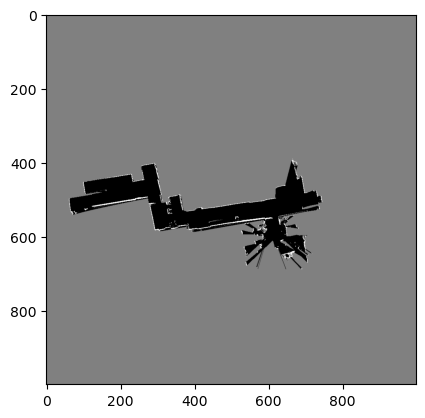

 34%|███▍      | 1702/4955 [09:08<17:28,  3.10it/s]


KeyboardInterrupt: 

In [10]:

# PREDICTION MODEL

weights=np.ones(N)/N

best_pose_estimate=np.empty([3,encoder_stamps.shape[0]-1])

for t in tqdm(range(encoder_stamps.shape[0]-1)):
    for i in range(N):
        noise = np.random.normal(0,0.001)
        omega = imu_angular_velocity[2,time_index[encoder_stamps[t]]]
        V_Rob=V_Robot[t]
        particles[0,i] = particles[0,i] + tau[0,t] * V_Rob * np.cos(particles[2,i]) + noise
        particles[1,i] = particles[1,i] + tau[0,t] * V_Rob * np.sin(particles[2,i]) + noise
        particles[2,i] = particles[2,i] + tau[0,t] * omega + noise
        

        # converting LIDAR scan to world frame from each particle pose
        
        lidar_scan_in_body = lidar_mes_body[:,:,time_index_lidar[encoder_stamps[t+1]]] # using the next lidar scan for mapping
        lidar_scan_world = lidar_scan_to_world(lidar_scan_in_body,particles[:,i])

        # FIND THE MAP CORRELATION AND UPDATE THE WEIGHTS OF EACH PARTICLE

        # NEED TO CHANGE THE x_range and y_range 
        x_range = np.arange(particles[0,i] - 0.2, particles[0,i] + 0.2 + map_resolution, map_resolution)
        y_range = np.arange(particles[1,i] - 0.2, particles[1,i] + 0.2 + map_resolution, map_resolution)
        res = mapCorrelation(binary_grid_map, x_map,y_map,lidar_scan_world, x_range,y_range)
        rob_idx = (res.shape[0]-1)//2
        max_row_index, max_col_index = np.unravel_index(np.argmax(res), res.shape)
        weights[i] = weights[i] * np.max(res)

    weights = weights / np.sum(weights)
    max_weight_index = np.argmax(weights)
    best_pose_estimate[:,t] = particles[:,max_weight_index]

    

    # update the map of the environment

    lidar_scan = lidar_scan_to_world(lidar_scan_in_body,best_pose_estimate[:,t])
        
    occupancy_grid_map,binary_grid_map = update_map(lidar_scan,occupancy_grid_map,binary_grid_map,best_pose_estimate[:,t])

    if t%100==0:
        clear_output()
        plt.imshow(occupancy_grid_map,cmap='gray')
        plt.show()


    # Resampling step
    N_eff = 1/np.sum(weights**2)    
    if N_eff <= N/10:
        particles = particles[:,np.random.choice(np.arange(0,N),N,p=weights)]
        weights = np.ones(N)/N
        

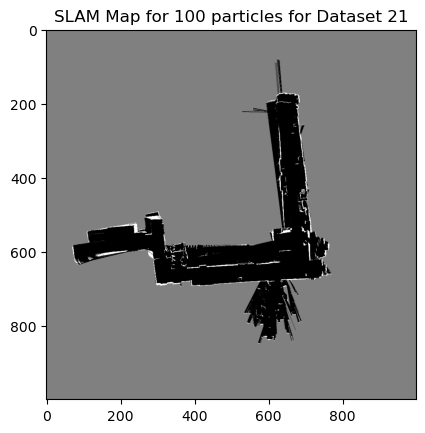

In [16]:
import pickle
with open('slam_log_{}N_Dataset {}.pickle'.format(N,dataset), 'wb') as f:
    pickle.dump(occupancy_grid_map, f)
with open('slam_traj_{}N_Dataset {}.pickle'.format(N,dataset), 'wb') as f:
    pickle.dump(best_pose_estimate, f)
    
plt.imshow(occupancy_grid_map,cmap='gray')
plt.title('SLAM Map for {} particles for Dataset {}'.format(N,dataset))
plt.savefig('SLAM Map for {} particles for Dataset {}'.format(N,dataset))
plt.show()


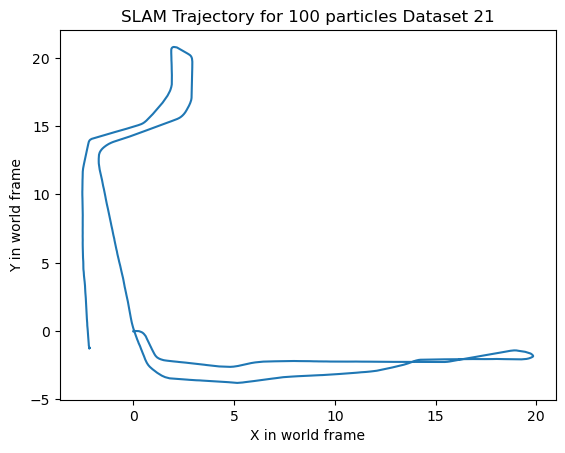

In [17]:

plt.plot(best_pose_estimate[0,:],best_pose_estimate[1,:])
plt.title('SLAM Trajectory for {} particles Dataset {}'.format(N,dataset))
plt.xlabel('X in world frame')
plt.ylabel('Y in world frame')
plt.savefig('SLAM Trajectory for {} particles Dataset {}'.format(N,dataset))
plt.show()

TEXTURE MAPPING

In [64]:
####
disp_stamps = kinect_data["disparity_time_stamps"] # acquisition times of the disparity images
rgb_stamps = kinect_data["rgb_time_stamps"] # acquisition times of the rgb images


time_index_rgb_disp={}

for t in rgb_stamps:
    time_diff = np.abs(disp_stamps - t)
    index = np.argmin(time_diff)
    time_index_rgb_disp[t]=index

time_index_rgb_encoder={}
for t in rgb_stamps:
    time_diff = np.abs(encoder_stamps - t)
    index = np.argmin(time_diff)
    time_index_rgb_encoder[t]=index

time_index_encoder_rgb={}
for t in encoder_stamps:
    time_diff = np.abs(rgb_stamps - t)
    index = np.argmin(time_diff)
    time_index_encoder_rgb[t]=index

1298445276.336908
1298445276.472103


In [65]:
def pix_cam_to_body(image):
    '''
    transforms from pixel locations camera regular frame to robot body frame
    '''
    pitch = 0.36 #rad
    yaw = 0.021 #rad
    roll=0.0
    pos = np.array([[0.18],[0.005],[0.36]])
    Rot_y = np.array([[np.cos(pitch),0,np.sin(pitch)],[0,1,0],[-np.sin(pitch),0,np.cos(pitch)]]) # pitch rotation
    Rot_z = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]]) # yaw rotation
    Rot_mat = transforms3d.euler.euler2mat(roll,pitch,yaw)
    res = np.matmul(Rot_mat,image) + pos
    return res


def pixel_to_cam(image):         
    '''
    transforms pixel locations to camera regular frame
    '''
    K = np.array([[585.05108211, 0, 242.94140713],[0, 585.05108211, 315.83800193],[0, 0, 1]], dtype=np.float32)

    
    reg_to_opt = np.array([[0,-1,0],[0,0,-1],[1,0,0]])
    opt_loc = np.matmul(np.linalg.inv(K),image)
    reg_loc = np.matmul(np.linalg.inv(reg_to_opt),opt_loc)
    return reg_loc

def pix_body_to_world(image,pose):
    '''
    function to convert the pixel locations in body frame to world frame
    '''
    x,y,theta=pose
    Rot_mat = np.array([[np.cos(theta),-np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1]])
    p1 = np.array([[x],[y],[0]])
    pix_world = np.matmul(Rot_mat,image) + p1
    return pix_world

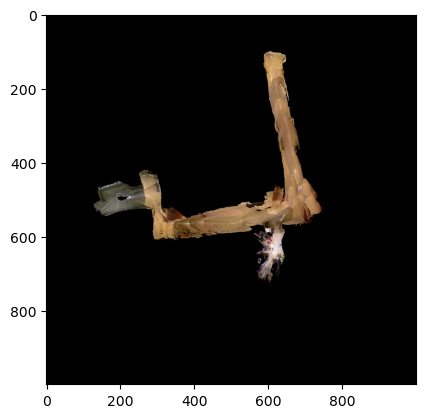

In [66]:

color_grid = np.zeros([num_grids_x,num_grids_y,3],dtype='uint8')


def normalize(img):
    max_ = img.max()
    min_ = img.min()
    return (img - min_)/(max_-min_)


for t in range(rgb_stamps.shape[0]-1): 

  disp_idx = time_index_rgb_disp[rgb_stamps[t]]+1
  
  imd = cv2.imread(disp_path+'disparity{}_{}.png'.format(20,disp_idx),cv2.IMREAD_UNCHANGED) # (480 x 640)
  imc = cv2.imread(rgb_path+'rgb{}_{}.png'.format(20, t+1))[...,::-1] # (480 x 640 x 3)
  #print(imc.shape)
  r, g, b = cv2.split(imc)

  # convert from disparity from uint16 to double
  disparity = imd.astype(np.float32)

  # get depth
  dd = (-0.00304 * disparity + 3.31)
  z = 1.03 / dd


  # calculate u and v coordinates 
  v,u = np.mgrid[0:disparity.shape[0],0:disparity.shape[1]]
  #u,v = np.meshgrid(np.arange(disparity.shape[1]),np.arange(disparity.shape[0]))

  # get 3D coordinates 
  fx = 585.05108211
  fy = 585.05108211
  cx = 315.83800193
  cy = 242.94140713
  x = (u-cx) / fx * z
  y = (v-cy) / fy * z

  # calculate the location of each pixel in the RGB image
  rgbu = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
  rgbv = np.round((v * 526.37 + 16662.0)/fy)
  valid = (rgbu>= 0)&(rgbu < disparity.shape[1])&(rgbv>=0)&(rgbv<disparity.shape[0])

  rows = rgbu.shape[0]
  cols = rgbv.shape[1]

  rgbu = rgbu.reshape(-1)
  rgbv = rgbv.reshape(-1)
  z=z.reshape(-1)
  u = rgbu * z
  v = rgbv * z
  image_mat = np.vstack((u,v,z))

  
  cam_frame_coords = pixel_to_cam(image_mat)
  body_frame_coords = pix_cam_to_body(cam_frame_coords)
  world_frame_coords = pix_body_to_world(body_frame_coords,best_pose_estimate[:,time_index_rgb_encoder[rgb_stamps[t]]-1])

  X_world = world_frame_coords[0,:]
  Y_world = world_frame_coords[1,:]
  Z_world = world_frame_coords[2,:]

  ind_thres = np.where(Z_world <=0.15)
  Y_world = Y_world[ind_thres]
  X_world = X_world[ind_thres]


  x_cell_idx = (rob_map_strt - (X_world//0.05)).astype(int)
  y_cell_idx = (rob_map_strt - (Y_world//0.05)).astype(int)

  r = r.reshape([rows*cols,1])[ind_thres]
  g = g.reshape([rows*cols,1])[ind_thres]
  b = b.reshape([rows*cols,1])[ind_thres]

  # r = r.reshape([rows*cols,1])
  # g = g.reshape([rows*cols,1])
  # b = b.reshape([rows*cols,1])

  #print(x_cell_idx.shape)


  color_grid[x_cell_idx,y_cell_idx,:] = np.hstack([r,g,b]) 

  if t%50 ==0:
     clear_output()
     plt.imshow(color_grid)
     plt.show()

    
  

  

  

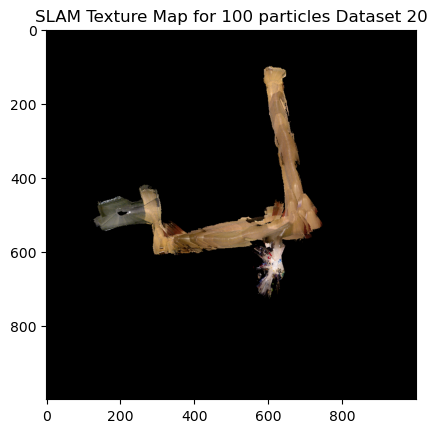

In [67]:
import pickle
with open('Texture_Map_SLAM_{} particles Dataset{}.pickle'.format(N,dataset), 'wb') as f:
    pickle.dump(color_grid, f)

plt.imshow(color_grid)
plt.title('SLAM Texture Map for {} particles Dataset {}'.format(N,dataset))
plt.savefig('SLAM Texture Map for {} particles Dataset {}'.format(N,dataset))
plt.show()